In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import multivariate_normal, norm, ks_2samp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle

from copy import deepcopy

import time

import tqdm

In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import roc_curve, auc

from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.drift_detection.ddm import DDM
from skmultiflow.drift_detection.eddm import EDDM
from skmultiflow.drift_detection.hddm_a import HDDM_A
from skmultiflow.drift_detection.hddm_w import HDDM_W
from skmultiflow.drift_detection.kswin import KSWIN
from skmultiflow.drift_detection.page_hinkley import PageHinkley

In [3]:
outdir = './output/synthetic/univariate/abrupt_mixture'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [4]:
class Theta:
    def __init__(self, pi, mu, sigma):
        self.pi = pi
        self.mu = mu
        self.sigma = sigma

In [5]:
def compute_tau(X, theta, eps=1e-12):
    #N = X.shape[0]
    K = len(theta.pi)
    
    #D = X.shape[1]
    D = X.shape[-1]    
    N = X.shape[-2]
    
    dim_X = len(X.shape)
        
    tau = np.zeros((N, K))
    for k in range(K):
        if D == 1:
            d_k = norm(theta.mu[k], np.sqrt(theta.sigma[k]))
        else:
            #if np.any(np.linalg.eigvals(theta.sigma[k, :, :]) <= 0.0):
            #    theta.sigma[k, :, :] = nearPD(theta.sigma[k, :, :])
            #d_k = multivariate_normal(theta.mu[k, :], theta.sigma[k, :, :])
            try:
                d_k = multivariate_normal(theta.mu[k, :], theta.sigma[k, :, :], 
                                          allow_singular=True)
            except:
                d_k = multivariate_normal(theta.mu[k, :], nearPD(theta.sigma[k, :, :]), 
                                          allow_singular=True)
        
        for i in range(N):
            if dim_X == 3:
                tau[i, k] = theta.pi[k] * d_k.pdf(X[k, i, :])
            elif dim_X == 2:
                tau[i, k] = theta.pi[k] * d_k.pdf(X[i, :])
                
    tau /= np.sum(tau, axis=1, keepdims=True)
    
    return tau

In [6]:
def compute_stat(X, Z):
    #N = X.shape[0]
    K = Z.shape[1]
    #D = X.shape[1]
    
    dim_X = len(X.shape)
    D = X.shape[-1]    
    N = X.shape[-2]
    
    #s1 = np.sum(Z, axis=0, keepdims=True)
    s1 = np.sum(Z.T, axis=1, keepdims=True)
    #s1 = np.mean(Z, axis=0, keepdims=True)
    #print('s1.shape:', s1.shape)
    if dim_X == 2:
        s2 = X.T.dot(Z).T
    elif dim_X == 3:
        s2 = np.einsum('kij,ik->kj', X, Z)
    #s2 = np.einsum('kij,ik->kj', X, Z)
    #print('s2.shape:', s2.shape)
    
    if dim_X == 2:
        #s3 = np.einsum('ijk,il->ljk', np.array([np.outer(X[i, :], X[i, :]) for i in range(X.shape[0])]), Z)
        s3 = np.einsum('ijk,il->ljk', np.array([np.outer(X[i, :], X[i, :]) for i in range(N)]), Z)
    else:
        #s3 = np.einsum('kijl,ik->kjl', np.array([[np.outer(X[k, i, :], X[k, i, :]) for i in range(X.shape[0])] for k in range(K)]), Z)
        s3 = np.einsum('kijl,ik->kjl', np.array([[np.outer(X[k, i, :], X[k, i, :]) for i in range(N)] for k in range(K)]), Z)
    #print('s3.shape:', s3.shape)
    
    return s1, s2, s3

In [7]:
def step_M(s, x, eps=1e-8):
    #print('s.s1')
    #print(s.s1)
    #print('s.s2')
    #print(s.s2)
    #print('s.s3')
    #print(s.s3)

    pi = (s.s1 + eps) / (1.0 + eps * len(s.s1))
    mu = s.s2 / (s.s1 + eps)
    sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.einsum('ij,ik->ijk', mu, mu)

    #print('pi')
    #print(pi)
    #print('mu')
    #print(mu)
    #print('sigma')
    #print(sigma)
    
    return pi, mu, sigma

In [8]:
class SuffStat:
    def __init__(self):
        pass

class SuffStatGMM(SuffStat):
    def __init__(self, K, D, seed=0):
        super().__init__()
        np.random.seed(seed)
        self.s1 = np.random.dirichlet([1.0]*K).reshape(-1, 1)
        self.s2 = np.random.random((K, D))
        self.s3 = np.random.random((K, D, D))

In [9]:
def generate_data(N, pi, mu, sigma):
    
    z_list = np.random.choice(np.arange(len(pi)), N, replace=True)
    
    X = np.zeros((N, 1))
    for i, z in enumerate(z_list):
        X_i = np.random.normal(mu[z], sigma[z])
        X[i, :] = X_i
    
    return X

## experiment (abrupt mean)

In [10]:
N = 10000
Nsim = 1

In [11]:
#pi = np.array([0.2, 0.8])
#pi = np.array([0.3, 0.7])
pi = np.array([1.0])
pi0 = pi.copy()

In [12]:
mean1 = 0.5
mu1 = np.array([mean1])

mean2 = 1.0
mu2 = np.array([mean2])

sigma = np.array([0.1])

In [13]:
seed0 = 1

In [14]:
theta = Theta(pi, mu1, sigma)
theta0 = Theta(pi, mu1, sigma)

In [15]:
seed = seed0
np.random.seed(seed)
X1 = generate_data(N, pi, mu1, sigma)
X2 = generate_data(N, pi, mu2, sigma)

X = np.vstack((X1, X2))

idxes_ol = np.random.choice(np.arange(N), int(0.01*N), replace=False)
X[idxes_ol, :] = np.random.uniform(-5, 5, len(idxes_ol)).reshape(-1, 1)

In [16]:
class SDEM(GaussianMixture):
    def __init__(self, r, alpha, n_components=2, **kwargs):
        super().__init__(n_components=n_components, **kwargs)
        
        self.r = r
        self.alpha = alpha
        self.t = 0
        
        self.pi_list = []
        self.pi_bar_list = []
        self.means_list = []
        self.means_bar_list = []
        self.covariances_list = []
        self.covariances_bar_list = []
        
    def fit(self, X, y=None):
        super().fit(X, y)
        self.means_bar = np.copy(self.means_)
        self.covariances_bar = np.copy(self.covariances_)
        
    def update(self, x):
        """Employ SDEM algorithm."""
        
        # E-step for weights
        gamma = (1-self.alpha*self.r[self.t]) * self.predict_proba(x.reshape(1, -1)) + self.alpha*self.r[self.t]/self.weights_.shape[0] # \overline{\gamma}_i^{(t)} in the paper
        gamma = gamma.ravel()
        self.weights_ = (1-self.r[self.t])*self.weights_ + self.r[self.t]*gamma
        
        x = x.ravel()
        means, means_bar, covariances, covariances_bar = [], [], [], []
        for i, (w, m, cov) in enumerate(zip(self.weights_, self.means_bar, self.covariances_bar)):
            # E-step
            m = (1-self.r[self.t])*m + self.r[self.t]*gamma[i]*x
            cov = (1-self.r[self.t])*cov + self.r[self.t]*gamma[i]*np.outer(x,x)
            means_bar.append(m)
            covariances_bar.append(cov)

            # M-step
            m = m/w
            cov = cov/w - np.outer(m, m)
            means.append(m)
            covariances.append(cov)

        self.means_ = np.vstack(means) # \mu_i^{(t)} in the paper
        self.covariances_ = np.stack(covariances)
        self.means_bar = np.stack(means_bar)
        self.covariances_bar = np.stack(covariances_bar)
        
        self.pi_list.append(self.weights_)
        self.means_list.append(self.means_)
        self.covariances_list.append(self.covariances_)
        self.means_bar_list.append(self.means_bar)
        self.covariances_bar_list.append(self.covariances_bar)
        
        self.t += 1

In [17]:
#def calc_scores_sdem(X, r, n_cluster, alpha=1.0, start=20, end=40, seed=0):
def calc_scores_sdem(X, X_init, r, n_cluster, alpha=1.0, score_start=20, seed=0):
    np.random.seed(seed)
    rho_const = np.repeat([r], X.shape[0])
    sdem = SDEM(rho_const, alpha, n_components=n_cluster)

    #X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(-1, X.shape[1])
    
    sdem.fit(X_init)

    for t in range(X.shape[0]):
        sdem.update(X[t, :])

    pi_est = np.array(sdem.pi_list)
    #pi_est = np.array(sdem.weights_)
    mu_est = np.array(sdem.means_bar_list)
    sigma_est = np.array(sdem.covariances_list)
    
    scores = [np.nan] * score_start
    
    #for t in range(start, pi_est.shape[0]):
    for t in range(score_start, X.shape[0]):
        p = np.zeros(n_cluster)
        if n_cluster >= 2:
            for k in range(n_cluster):
                p_k = pi_est[t-1, k] * norm(mu_est[t-1, k, :], np.sqrt(sigma_est[t-1, k, :, :])).pdf(X[t, :])
                p[k] = p_k
        else:
            p[0] = pi_est[t-1] * norm(mu_est[t-1, 0, :], np.sqrt(sigma_est[t-1, :, :])).pdf(X[t, :])
        p_tot = np.sum(p)
        if p_tot >= 1.0/np.finfo(float).max:
            scores.append(-np.log(p_tot))
        else:
            scores.append(np.log(np.finfo(float).max))
    scores = np.array(scores)
    
    return scores

In [18]:
#def calc_scores_iem(X, n_cluster, alpha=1.0, start=20, end=40, seed=0):
def calc_scores_iem(X, X_init, n_cluster, alpha=1.0, score_start=0, seed=0):
    np.random.seed(seed)
    rhos = 1.0 / np.arange(1, X.shape[0]+1)
    #sdem = SDEM(rhos, alpha, n_components=k)
    sdem = SDEM(rhos, alpha, n_components=n_cluster)

    #xmin = np.min(X[start:end, :])
    #xmax = np.max(X[start:end, :])
    
    #X_init = np.random.uniform(xmin, xmax, 20).reshape(20, X.shape[1])
    sdem.fit(X_init)
    
    for t in range(X.shape[0]):
        sdem.update(X[t, :])

    pi_est = np.array(sdem.pi_list)
    mu_est = np.array(sdem.means_list)
    sigma_est = np.array(sdem.covariances_list)
    
    #scores = [np.nan] * start
    scores = [np.nan] * score_start

    """
    n_cluster = pi_est.shape[1]
    for t in range(start, X.shape[0]):
        p = np.zeros(n_cluster)
        for i in range(n_cluster):
            p_i = pi_est[t-1, i] * norm(mu_est[t-1, i, :], np.sqrt(sigma_est[t-1, i, :, :])).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            scores.append(-np.log(p_tot))
        else:
            scores.append(-np.log(-1.0/np.finfo(np.float).min))
    scores = np.array(scores)
    """
    #for t in range(start, pi_est.shape[0]):
    for t in range(score_start, X.shape[0]):
        p = np.zeros(n_cluster)
        if n_cluster >= 2:
            for k in range(n_cluster):
                p_k = pi_est[t-1, k] * norm(mu_est[t-1, k, :], np.sqrt(sigma_est[t-1, k, :, :])).pdf(X[t, :])
                p[k] = p_k
        else:
            p[0] = pi_est[t-1] * norm(mu_est[t-1, 0, :], np.sqrt(sigma_est[t-1, :, :])).pdf(X[t, :])
        p_tot = np.sum(p)
        if p_tot >= 1.0/np.finfo(float).max:
            scores.append(-np.log(p_tot))
        else:
            scores.append(np.log(np.finfo(float).max))
    scores = np.array(scores)
    
    return scores

In [19]:
"""
def sem(X, theta0, rho, start, end, seed):
    np.random.seed(seed)
    
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    
    theta = deepcopy(theta0)
    pi_est = np.nan * np.ones((N, K, 1))
    mu_est = np.nan * np.ones((N, K, D))
    sigma_est = np.nan * np.ones((N, K, D, D))
    
    s = SuffStatGMM(K, D)
    
    X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(-1, X.shape[1])
    
    # initialization
    tau = compute_tau(X_init, theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X_init, tau)

    
    inds = np.arange(N)
    
    for n in range(start, N):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        
        if np.any(np.isnan(tau_indiv_new)):
            pi_est[n, :] = theta.pi.copy()
            mu_est[n, :, :] = theta.mu.copy()
            sigma_est[n, :, :, :] = theta.sigma.copy()
            continue
        
        if K == 1:
            s.s1 += rho[n] * (tau_indiv_new.ravel() - s.s1)
            s.s2 += rho[n] * (s2_indiv_new.ravel() - s.s2)
            s.s3 += rho[n] * (s3_indiv_new.ravel() - s.s3)
        else:
            s.s1 += rho[n] * (tau_indiv_new - s.s1)
            s.s2 += rho[n] * (s2_indiv_new - s.s2)
            s.s3 += rho[n] * (s3_indiv_new - s.s3)

        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, 1)
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()
        
    return pi_est, mu_est, sigma_est
"""

"\ndef sem(X, theta0, rho, start, end, seed):\n    np.random.seed(seed)\n    \n    K = len(theta0.mu)\n    N = X.shape[0]\n    D = X.shape[1]\n    \n    theta = deepcopy(theta0)\n    pi_est = np.nan * np.ones((N, K, 1))\n    mu_est = np.nan * np.ones((N, K, D))\n    sigma_est = np.nan * np.ones((N, K, D, D))\n    \n    s = SuffStatGMM(K, D)\n    \n    X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(-1, X.shape[1])\n    \n    # initialization\n    tau = compute_tau(X_init, theta)\n    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X_init, tau)\n\n    \n    inds = np.arange(N)\n    \n    for n in range(start, N):\n        ind_n = inds[n]\n        \n        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)\n        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])\n        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))\n        \n        if np.any(np.isnan(tau_indiv_new)):\n 

In [20]:
"""
def sem(X, theta0, rho, start, end, seed):
    np.random.seed(seed)
    
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    
    theta = deepcopy(theta0)
    pi_est = np.nan * np.ones((N, K, 1))
    mu_est = np.nan * np.ones((N, K, D))
    sigma_est = np.nan * np.ones((N, K, D, D))
    
    s = SuffStatGMM(K, D)
    
    #X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(-1, X.shape[1])
    #X_init = np.random.uniform(-2, 2, 20).reshape(-1, X.shape[1])
    #X_init = X[start:end, :].reshape(-1, X.shape[1])
    X_init = X[:10, :].reshape(-1, X.shape[1])
    
    # initialization
    tau = compute_tau(X_init, theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X_init, tau)

    
    inds = np.arange(N)
    
    for n in range(start, N):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        
        if np.any(np.isnan(tau_indiv_new)):
            pi_est[n, :] = theta.pi.copy()
            mu_est[n, :, :] = theta.mu.copy()
            sigma_est[n, :, :, :] = theta.sigma.copy()
            continue
        
        if K == 1:
            s.s1 += rho[n] * (tau_indiv_new.ravel() - s.s1)
            s.s2 += rho[n] * (s2_indiv_new.ravel() - s.s2)
            s.s3 += rho[n] * (s3_indiv_new.ravel() - s.s3)
        else:
            s.s1 += rho[n] * (tau_indiv_new - s.s1)
            #s.s1 += rho[n] * (tau_indiv_new.ravel() - s.s1)
            s.s2 += rho[n] * (s2_indiv_new - s.s2)
            s.s3 += rho[n] * (s3_indiv_new - s.s3)

        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, 1)
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()
        
    return pi_est, mu_est, sigma_est
"""

"\ndef sem(X, theta0, rho, start, end, seed):\n    np.random.seed(seed)\n    \n    K = len(theta0.mu)\n    N = X.shape[0]\n    D = X.shape[1]\n    \n    theta = deepcopy(theta0)\n    pi_est = np.nan * np.ones((N, K, 1))\n    mu_est = np.nan * np.ones((N, K, D))\n    sigma_est = np.nan * np.ones((N, K, D, D))\n    \n    s = SuffStatGMM(K, D)\n    \n    #X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(-1, X.shape[1])\n    #X_init = np.random.uniform(-2, 2, 20).reshape(-1, X.shape[1])\n    #X_init = X[start:end, :].reshape(-1, X.shape[1])\n    X_init = X[:10, :].reshape(-1, X.shape[1])\n    \n    # initialization\n    tau = compute_tau(X_init, theta)\n    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X_init, tau)\n\n    \n    inds = np.arange(N)\n    \n    for n in range(start, N):\n        ind_n = inds[n]\n        \n        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)\n        s2_indiv_new = np.outer(tau_indiv_new, X[in

In [21]:
#def sem(X, theta0, rho, start, end, seed):
def sem(X, X_init, theta0, rho, score_start, seed):
    np.random.seed(seed)
    
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    
    theta = deepcopy(theta0)
    pi_est = np.nan * np.ones((N, K, 1))
    mu_est = np.nan * np.ones((N, K, D))
    sigma_est = np.nan * np.ones((N, K, D, D))
    
    s = SuffStatGMM(K, D)
    
    #X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(-1, X.shape[1])
    #X_init = np.random.uniform(-2, 2, 20).reshape(-1, X.shape[1])
    #X_init = X[start:end, :].reshape(-1, X.shape[1])
    #X_init = X[:10, :].reshape(-1, X.shape[1])
    #X_init = np.random.uniform(-2, 2, 10).reshape(-1, X.shape[1])
    
    # initialization
    tau = compute_tau(X_init, theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X_init, tau)

    
    inds = np.arange(N)
    
    #for n in range(start, N):
    for n in range(score_start, N):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        
        if np.any(np.isnan(tau_indiv_new)):
            pi_est[n, :] = theta.pi.copy()
            mu_est[n, :, :] = theta.mu.copy()
            sigma_est[n, :, :, :] = theta.sigma.copy()
            continue
        
        if K == 1:
            s.s1 += rho[n] * (tau_indiv_new.ravel() - s.s1)
            s.s2 += rho[n] * (s2_indiv_new.ravel() - s.s2)
            s.s3 += rho[n] * (s3_indiv_new.ravel() - s.s3)
        else:
            """
            print('tau_indiv_new:', tau_indiv_new.shape)
            print('s.s1:', s.s1.shape)
            print('s2_indiv_new:', s2_indiv_new.shape)
            print('s.s2:', s.s2.shape)
            print('s3_indiv_new:', s3_indiv_new.shape)
            print('s.s3:', s.s3.shape)
            """
            s.s1 += rho[n] * (tau_indiv_new - s.s1)
            #s.s1 += rho[n] * (tau_indiv_new.ravel() - s.s1)
            s.s2 += rho[n] * (s2_indiv_new - s.s2)
            s.s3 += rho[n] * (s3_indiv_new - s.s3)

        # M-step
        """
        print(step_M(s, 1))
        print(theta.pi.shape)
        print(step_M(s, X[ind_n, :])[0])
        print(theta.mu.shape)
        print(step_M(s, X[ind_n, :])[1])
        print(theta.sigma.shape)
        print(step_M(s, X[ind_n, :])[2])
        """
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, 1)
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()
        
    return pi_est, mu_est, sigma_est

In [22]:
#def calc_scores_sem(X, theta0, r, k, start=20, end=40, seed=0):
def calc_scores_sem(X, X_init, theta0, r, k, score_start=0, seed=0):
    rho_const = np.repeat([r], X.shape[0])
    #pi_est, mu_est, sigma_est = sem(X, theta0, rho_const, start, end, seed)
    pi_est, mu_est, sigma_est = sem(X, X_init, theta0, rho_const, score_start, seed)
    
    #plt.plot(X.ravel())
    #plt.plot(mu_est.ravel(), linestyle='dashed')
    #plt.show()
    
    #scores = [np.nan]*start
    scores = [np.nan]*score_start
    #for t in range(start, pi_est.shape[0]):
    for t in range(score_start, X.shape[0]):
        p = np.zeros(k)
        for i in range(k):
            p_i = pi_est[t-1, i] * norm(mu_est[t-1, i, :], np.sqrt(sigma_est[t-1, i, :, :])).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1.0/np.finfo(float).max:
            scores.append(-np.log(p_tot))
        else:
            scores.append(np.log(np.finfo(float).max))
            
    return scores


In [23]:
#def sra(X, theta0, rho, gamma, t_start=50, start=20, end=40):
def sra(X, X_init, theta0, rho, gamma, t_start=50, score_start=0):
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    
    pi_est = np.nan * np.ones((N, K, 1))
    mu_est = np.nan * np.ones((N, K, D))
    sigma_est = np.nan * np.ones((N, K, D, D))
    theta = deepcopy(theta0)
    
    s = SuffStatGMM(K, D)
    
    #X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(20, X.shape[1])
    #X_init = np.random.uniform(-2, 2, 20).reshape(20, X.shape[1])
    
    # initialization
    tau = compute_tau(X_init, theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X_init, tau)

    outliers = []
    
    inds = np.arange(N)
    
    for n in range(score_start, N):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        
        #if ( np.any(np.isnan(tau_indiv_new)) ) | ( (n >= t_start) &  (np.linalg.norm(s2_indiv_new - s.s2) >= gamma) ):
        if ( np.any(np.isnan(tau_indiv_new)) ) | ( (n >= t_start) &  (np.linalg.norm(s2_indiv_new - s.s2) >= gamma) ):
            pi_est[n, :] = theta.pi.copy()
            mu_est[n, :, :] = theta.mu.copy()
            sigma_est[n, :, :, :] = theta.sigma.copy()
            
            outliers.append(n)
            
            continue
            
        # update the statistics
        if K == 1:
            s.s1 += rho[n] * (tau_indiv_new.ravel() - s.s1)
            s.s2 += rho[n] * (s2_indiv_new.ravel() - s.s2)
            s.s3 += rho[n] * (s3_indiv_new.ravel() - s.s3)
        else:
            #s.s1 += rho[n] * (tau_indiv_new.ravel() - s.s1)
            #s.s2 += rho[n] * (s2_indiv_new.ravel() - s.s2)
            #s.s3 += rho[n] * (s3_indiv_new.ravel() - s.s3)
            s.s1 += rho[n] * (tau_indiv_new - s.s1)
            s.s2 += rho[n] * (s2_indiv_new - s.s2)
            s.s3 += rho[n] * (s3_indiv_new - s.s3)

        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, X[ind_n, :])
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()

    return pi_est, mu_est, sigma_est, outliers

In [24]:
#def calc_scores_sra(X, theta0, k, gamma, ratio, M, t_start=1500, start=20, seed=0):
def calc_scores_sra(X, X_init, theta0, k, gamma, ratio, M, t_start=50, score_start=0, seed=0):    
    np.random.seed(seed)
    
    rho = ratio * np.exp(-gamma**2/M**2) / (2.0*gamma)
    rho_const = np.repeat(rho, X.shape[0])
    #pi_est, mu_est, sigma_est, outliers = sra(X, theta0, rho_const, gamma, t_start=t_start, start=start)
    pi_est, mu_est, sigma_est, outliers = sra(X, X_init, theta0, rho_const, gamma, t_start=t_start, score_start=score_start)
        
    #scores = [np.nan] * start
    scores = [np.nan] * score_start
    #for t in range(start, pi_est.shape[0]):
    for t in range(score_start, X.shape[0]):
        if t in outliers:
            #score_t = np.nan
            score_t = scores[-1]
        else:
            p = np.zeros(k)
            for i in range(k):
                p_i = pi_est[t-1, i] * norm(mu_est[t-1, i, :], np.sqrt(sigma_est[t-1, i, :, :])).pdf(X[t, :])
                p[i] = p_i
            p_tot = np.sum(p)
            if p_tot >= 1.0/np.finfo(float).max:
                score_t = -np.log(p_tot)
            else:
                score_t = np.log(np.finfo(float).max)
        scores.append(score_t)
    return scores

In [25]:
def calc_metrics(means, mu1, mu2, eval_start=500, eval_end=1000, burnin=1000, N=10000):
    ev = np.sum((means[eval_start:eval_end, :] - mu1)**2, axis=1)
    former = np.sum((means[burnin:N, :] - mu1)**2, axis=1)
    latter = np.sum((means[N:, :] - mu2)**2, axis=1)
    print('former')
    print(former.shape)
    print(former)
    print('latter')
    print(latter.shape)
    print(latter)
    overall = np.hstack((former, latter))
    
    #return np.mean(ev), np.mean(former), np.mean(latter), np.mean(overall)
    return np.nanmean(ev), np.nanmean(former), np.nanmean(latter), np.nanmean(overall)

In [26]:
def calc_falarms_benefit(scores, change_points, start=None, end=None, T=100, N_thr=100, eps=1e-2):
    scores_max, scores_min = np.nanmax(scores), np.nanmin(scores)
    threshold_list = np.linspace(scores_min - eps, scores_max + eps, N_thr)

    falarms = []
    benefits = []
    
    N = len(scores)
    
    for threshold in threshold_list:
        binary_alarm = (np.array(scores) >= threshold)
        
        benefit = np.zeros(N)
        for cp in change_points:
            if cp < T:
                # t = 0, ... , cp, cp+1, ..., cp+T-1
                values = 1.0 - np.hstack((np.arange(cp, 0, -1), np.arange(T)))/T
                benefit[:(cp+T)] = values
            elif cp+T > N:
                # t = cp-T, ..., cp, cp+1, ..., N-1
                values = 1.0 - np.hstack((np.arange(T, 0, -1), np.arange(N-cp)))/T
                benefit[(cp-T):] = values
            else:
                # t = cp-T, ..., cp, cp+1, ..., cp+T-1
                values = 1.0 - np.hstack((np.arange(T, 0, -1), np.arange(T)))/T
                benefit[(cp-T):(cp+T)] = values
            
        if start is not None:
            if end is not None:
                benefit = benefit[start:end]
                binary_alarm = binary_alarm[start:end]
            else:
                benefit = benefit[start:]
                binary_alarm = binary_alarm[start:]
        elif end is not None:
            benefit = benefit[:end]
            binary_alarm = binary_alarm[:end]
        
        total_benefit = np.sum(binary_alarm * benefit)
        n_falarm = np.sum(binary_alarm * (benefit == 0.0).astype(int))
        
        benefits.append(total_benefit/np.sum(benefit))
        falarms.append(n_falarm/np.sum(benefit == 0.0))

    benefits = np.array(benefits)    
    falarms = np.array(falarms)
    
    return falarms, benefits

In [27]:
def calc_auc_main(scores, cps, start, end, T, N_thr=100):
    falarms, benefits = calc_falarms_benefit(scores, cps, start=start, end=end, T=T, N_thr=N_thr)
    auc_ = auc(falarms, benefits)

    return auc_

## AUC

In [35]:
def experiment1_comparison_auc(
    # ADWIN
    delta_list_adwin=[0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5], 
    # KSWIN
    alpha_list_kswin = [0.001, 0.005, 0.01], 
    window_size_list_kswin = [20, 30], 
    stat_size_list_kswin = [10, 15], 
    # DDM
    min_num_instances_list_ddm=[10, 20, 30, 40, 50, 100], 
    # EDDM
    min_num_instances_list_eddm=[10, 20, 30, 40, 50, 100],
    # Page-Hinkley
    threshold_list_ph=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
    # SDEM
    r_list_sdem=[0.0001, 0.001, 0.005, 0.01], 
    # SEM
    r_list_sem=[0.01, 0.05, 0.1],
    # SRA
    gamma_list_sra=[1, 3, 5, 10, 15], 
    ratio_list_sra=[0.1, 0.2, 0.3, 0.5], 
    M_list_sra=[5, 10, 15], 
    #gamma=3.0, 
    #ratio=0.1, 
    #M=5.0, 
    u=10, 
    N=10000,
    alpha_ol=0.01, # ratio of outliers
    burnin=1000,
    pi=np.array([0.5, 0.5]),
    mu1=np.array([0.5, -0.5]),
    mu2=np.array([1.0, -1.0]),
    sigma = np.array([0.1, 0.1]),
    cps=np.array([9999]),
    #start=0, 
    #end=None,
    score_start=0, 
    score_end=None,
    T=100,
    K=2, 
    N_thr=1000,
    n_trial=10):

    auc_adwin = []
    auc_kswin = []
    auc_ddm = []
    auc_eddm = []
    auc_ph = []
    auc_sdem = []
    auc_iem = []
    auc_sem = []
    auc_sra = []
    
    time_adwin = []
    time_kswin = []
    time_ddm = []
    time_eddm = []
    time_ph = []
    time_sdem = []
    time_iem = []
    time_sem = []
    time_sra = []
    
    for trial in tqdm.tqdm(range(n_trial)):
        # generate data
        np.random.seed(trial)
        X = np.zeros((2*N, 1))
        Xj_former = generate_data(N, pi, mu1, sigma)
        X[:N, 0] = Xj_former.ravel()
        Xj_latter = generate_data(N, pi, mu2, sigma)
        X[N:, 0] = Xj_latter.ravel()

        idxes_ol = np.random.choice(np.arange(2*N), int(alpha_ol*2*N))
        X[idxes_ol, :] = np.random.uniform(-u, u, len(idxes_ol)).reshape(-1, 1)
        
        print('# ADWIN')
        time_adwin_each = []
        for i, delta in enumerate(delta_list_adwin):
            #print(f"delta = {delta}")
            score_list_adwin = []
            
            time_start = time.time()
            
            adwin = ADWIN(delta=delta)
            for t, x in enumerate(X.ravel()):
                adwin.add_element(x)
                
                score_list_adwin.append(adwin._width)
                
                #if adwin.detected_change():
                #    score = 1.0
                #else:
                #    score = 0.0
                #   
                #score_list_adwin.append(score)
            
            time_end = time.time()
            time_adwin_each.append(time_end - time_start)
            
            score_list_adwin = np.hstack((np.nan, np.abs(np.diff(score_list_adwin))))
            
            #ev, former, latter, total = calc_metrics(np.vstack(score_list_adwin), mu1, mu2, eval_start, eval_end, burnin)
            #auc_ = calc_auc_main(score_list_adwin, cps, start, end, T, N_thr)
            auc_ = calc_auc_main(score_list_adwin, cps, score_start, score_end, T, N_thr)
            #auc_adwin[trial, i] = auc_
            auc_adwin.append([trial, delta, auc_])
        
        time_adwin.append(time_adwin_each)
        
        print('# KSWIN')
        time_kswin_each = []
        for i, alpha in enumerate(alpha_list_kswin):
            for j, window_size in enumerate(window_size_list_kswin):
                for k, stat_size in enumerate(stat_size_list_kswin):
                    score_list_kswin = []
                    
                    time_start = time.time()
                    
                    kswin = KSWIN(alpha=alpha, window_size=window_size, stat_size=stat_size)
                    for t, x in enumerate(X.ravel()):
                        kswin.add_element(x)
                        
                        #if kswin.detected_change():
                        #    score = 1.0
                        #else:
                        #    score = 0.0
                        currentLength = kswin.window.shape[0]
                        if currentLength >= kswin.window_size:
                            window = np.delete(kswin.window, 0)
                            rnd_window = np.random.choice(kswin.window[:stat_size], stat_size)

                            (st, p_value) = ks_2samp(rnd_window, kswin.window[-stat_size:], mode="exact")

                            score = 1.0 - p_value
                        else:
                            score = 0.0
                        
                        score_list_kswin.append(score)
                    
                    #score_list_kswin = np.hstack((np.nan, np.abs(np.diff(score_list_kswin))))
                    
                    time_end = time.time()
                    time_kswin_each.append(time_end - time_start)
                    
                    #auc_ = calc_auc_main(score_list_kswin, cps, start, end, T, N_thr)
                    auc_ = calc_auc_main(score_list_kswin, cps, score_start, score_end, T, N_thr)
                    auc_kswin.append([trial, alpha, window_size, stat_size, auc_])
        
        time_kswin.append(time_kswin_each)
        
        print('# DDM')
        time_ddm_each = []
        for i, min_num_instances in enumerate(min_num_instances_list_ddm):
            score_list_ddm = []
            
            time_start = time.time()
            ddm = DDM(min_num_instances=min_num_instances)
            err = 0
            for t in range(X.shape[0]):
                ddm.add_element(err)
                score_t = ddm.miss_prob + ddm.miss_std - ddm.miss_prob_min - ddm.out_control_level*ddm.miss_sd_min
                score_list_ddm.append(score_t)

                if ddm.detected_change():
                    #if t in [9999]:
                    if t in np.hstack((idxes_ol, N-1)):
                        err = 0
                    else:
                        err = 1
                else:
                    #if t in [9999]:
                    if t in np.hstack((idxes_ol, N-1)):
                        err = 1
                    else:
                        err = 0
            time_end = time.time()
            time_ddm_each.append(time_end - time_start)

            #ev, former, latter, total = calc_metrics(score_list_ddm, mu1, mu2, eval_start, eval_end, burnin)
            #auc_ = calc_auc_main(score_list_ddm, cps, start, end, T, N_thr)
            auc_ = calc_auc_main(score_list_ddm, cps, score_start, score_end, T, N_thr)
            #auc_ddm[trial, i] = auc_
            auc_ddm.append([trial, min_num_instances, auc_])
        
        time_ddm.append(time_ddm_each)
        
        print('# EDDM')
        time_eddm_each = []
        for i, min_num_instances in enumerate(min_num_instances_list_ddm):
            #print(f"min_num_instances = {min_num_instances}")
            score_list_eddm = []
            
            time_start = time.time()
            eddm = EDDM()
            err = 0.0
            for t in range(X.shape[0]):
                eddm.add_element(err)
                score_t = eddm.m_num_errors - eddm.m_min_num_errors

                score_list_eddm.append(score_t)
                if eddm.detected_change():
                    #print(f"t = {t}")
                    #if t in [9999]:
                    if t in np.hstack((idxes_ol, N-1)):
                        err = 0
                    else:
                        err = 1
                else:
                    #if t in [9999]:
                    if t in np.hstack((idxes_ol, N-1)):
                        err = 1
                    else:
                        err = 0
            time_end = time.time()
            time_eddm_each.append(time_end - time_start)

            #ev, former, latter, total = calc_metrics(score_list_eddm, mu1, mu2, eval_start, eval_end, burnin)
            #auc_ = calc_auc_main(score_list_eddm, cps, start, end, T, N_thr)
            auc_ = calc_auc_main(score_list_eddm, cps, score_start, score_end, T, N_thr)
            #auc_eddm[trial, i] = auc_
            auc_eddm.append([trial, min_num_instances, auc_])

        time_eddm.append(time_eddm_each)

        print('# Page-Hinkley')
        time_ph_each = []
        for i, threshold in enumerate(threshold_list_ph):
            score_list_ph = []
            
            time_start = time.time()
            ph = PageHinkley()
            for t in range(X.shape[0]):
                ph.add_element(X[t, :])
                score_t = ph.sum - threshold
                score_list_ph.append(score_t)

            time_end = time.time()
            time_ph_each.append(time_end - time_start)
            
            #ev, former, latter, total = calc_metrics(score_list_ph, mu1, mu2, eval_start, eval_end, burnin)
            #auc_ = calc_auc_main(score_list_ph, cps, start, end, T, N_thr)
            auc_ = calc_auc_main(score_list_ph, cps, score_start, score_end, T, N_thr)
            #auc_ph[trial, i] = auc_
            auc_ph.append([trial, threshold, auc_])
        
        time_ph.append(time_ph_each)
        
        print('# SDEM')
        time_sdem_each = []
        for i, r in enumerate(r_list_sdem):
            time_start = time.time()
            rho_const = np.repeat([r], 2*N)
            sdem = SDEM(rho_const, 1.0, n_components=K)
            seed = i*len(r_list_sdem) + trial
            
            X_init = np.random.uniform(
                         -5, 5, 
                     20).reshape(-1, 1) 
                                           
            #scores_sdem = calc_scores_sdem(X, r, n_cluster=K, start=0, alpha=1.0, seed=seed)
            scores_sdem = calc_scores_sdem(X, X_init, r, n_cluster=K, score_start=score_start,  
                                           alpha=1.0, seed=seed)
            time_end = time.time()
            
            time_sdem_each.append(time_end - time_start)
            
            #auc_ = calc_auc_main(scores_sdem, cps, start, end, T, N_thr)
            auc_ = calc_auc_main(scores_sdem, cps, score_start, score_end, T, N_thr)
            auc_sdem.append([trial, r, auc_])

        time_sdem.append(time_sdem_each)
        
        print('# IEM')
        time_iem_each = []
        
        time_start = time.time()
        iem = SDEM(1.0/np.arange(1, 2*N+1), 1.0, n_components=K)
        X_init = np.random.uniform(
                     -5, 5, 
                 20).reshape(-1, 1)
        #scores_iem = calc_scores_iem(X, n_cluster=K, start=0, seed=trial)
        scores_iem = calc_scores_iem(X, X_init, n_cluster=K, score_start=score_start, seed=trial)
        time_end = time.time()
        
        time_iem_each.append(time_end - time_start)
        
        #auc_ = calc_auc_main(scores_iem, cps, start, end, T, N_thr)
        auc_ = calc_auc_main(scores_iem, cps, score_start, score_end, T, N_thr)
        auc_iem.append([trial, auc_])
        
        time_iem.append(time_iem_each)
        
        print('# SEM')
        time_sem_each = []
        for i, r in enumerate(r_list_sem):
            seed = i*len(r_list_sem) + trial
            np.random.seed(seed)

            time_start = time.time()
            #pi0 = np.array([1.0]).reshape(-1, 1)
            #X_init = np.random.uniform(np.min(X[20:40, :]), np.max(X[20:40, :]), 20).reshape(20, X.shape[1])
            
            #mu0 = [np.mean(X_init)]
            #sigma0 = np.array([[np.std(X_init)]])
            pi0 = np.random.dirichlet([1.0]*2).reshape(-1, 1)
            #X_init = np.random.uniform(np.min(X[20:40, :]), np.max(X[20:40, :]), 20).reshape(20, X.shape[1])
            #X_init = np.random.uniform(-2, 2, 20).reshape(20, X.shape[1])
            #mu0 = np.sort(np.random.uniform(np.min(X_init), np.max(X_init), 2))[::-1].reshape(-1, 1)
            #sigma0 = np.array([[[np.std(X_init)]], [[np.std(X_init)]]])

            X_init = np.array([np.hstack([ np.random.uniform(
                                                #np.min(X[20:40, j]), 
                                                #np.max(X[20:40, j]), 
                                                -5, 5, 
                                            20).reshape(-1, 1) 
                                           for j in range(X.shape[1]) ]) for _ in range(K)])

            mu0 = np.mean(X_init, axis=1)
            sigma0 = np.array([[[np.std(X_init[kk, :, :])]] for kk in range(K)])            
            
            theta0 = Theta(pi0, mu0, sigma0)

            #scores_sem = calc_scores_sem(X, theta0, r, k=K, seed=seed)
            scores_sem = calc_scores_sem(X, X_init, theta0, r, k=K, score_start=score_start, seed=seed)
            
            time_end = time.time()
            time_sem_each.append(time_end - time_start)
            
            #auc_ = calc_auc_main(scores_sem, cps, start, end, T, N_thr)
            auc_ = calc_auc_main(scores_sem, cps, score_start, score_end, T, N_thr)
            auc_sem.append([trial, r, auc_])
            
        time_sem.append(time_sem_each)
        
        print('# SRA')
        time_sra_each = []
        for j, gamma in enumerate(gamma_list_sra):
            #ratio_list = [0.01*gamma, 0.03*gamma, 0.05*gamma, 0.1*gamma]
            #M_list = [gamma, 2*gamma, 4*gamma]
            for l, ratio in enumerate(ratio_list_sra):
                for m, M in enumerate(M_list_sra):
                    seed = j*len(gamma_list_sra) + l*len(ratio_list_sra) + m * len(M_list_sra) + trial
                    
                    np.random.seed(seed)
                    
                    time_start = time.time()
                    #pi0 = np.array([1.0])
                    #X_init = np.random.uniform(np.min(X[20:40, :]), np.max(X[20:40, :]), 20)
                    #mu0 = np.array([np.mean(X_init)])
                    #sigma0 = np.array([[np.var(X_init)]])
                    #theta0 = Theta(pi0, mu0, sigma0)
                    
                    pi0 = np.random.dirichlet([1.0]*2).reshape(-1, 1)
                    X_init = np.array([np.hstack([ np.random.uniform(
                                                        #np.min(X[20:40, j]), 
                                                        #np.max(X[20:40, j]), 
                                                        -5, 5, 
                                                        20).reshape(-1, 1) 
                                                   for j in range(X.shape[1]) ]) for _ in range(K)])
                    mu0 = np.mean(X_init, axis=1)
                    sigma0 = np.array([[[np.std(X_init[kk, :, :])]] for kk in range(K)])            

                    theta0 = Theta(pi0, mu0, sigma0)
                    
                    #scores_sra = calc_scores_sra(X, theta0, k=K, gamma=gamma, ratio=ratio, M=M, seed=seed)
                    scores_sra = calc_scores_sra(X, X_init, theta0, k=K, gamma=gamma, ratio=ratio, M=M, 
                                                 score_start=score_start, seed=seed)

                    time_end = time.time()
                    time_sra_each.append(time_end - time_start)
                    
                    #auc_ = calc_auc_main(scores_sra, cps, start, end, T, N_thr)
                    auc_ = calc_auc_main(scores_sra, cps, score_start, score_end, T, N_thr)
                    auc_sra.append([trial, gamma, ratio, M, auc_])

        time_sra.append(time_sra_each)            
        
    auc_adwin_df = pd.DataFrame(auc_adwin, columns=['trial', 'delta', 'auc'])
    auc_kswin_df = pd.DataFrame(auc_kswin, columns=['trial', 'alpha', 'window_size', 'stat_size', 'auc'])
    auc_ddm_df = pd.DataFrame(auc_ddm, columns=['trial', 'min_num_instances', 'auc'])
    auc_eddm_df = pd.DataFrame(auc_eddm, columns=['trial', 'min_num_instances', 'auc'])
    auc_ph_df = pd.DataFrame(auc_ph, columns=['trial', 'threshold', 'auc'])

    auc_sdem_df = pd.DataFrame(auc_sdem, columns=['trial', 'r', 'auc'])
    auc_iem_df = pd.DataFrame(auc_iem, columns=['trial', 'auc'])
    auc_sem_df = pd.DataFrame(auc_sem, columns=['trial', 'r', 'auc'])    
    auc_sra_df = pd.DataFrame(auc_sra, columns=['trial', 'gamma', 'ratio', 'M', 'auc'])

    return auc_adwin_df, auc_kswin_df, auc_ddm_df, auc_eddm_df, auc_ph_df, \
           auc_sdem_df, auc_iem_df, auc_sem_df, auc_sra_df, \
           time_adwin, time_kswin, time_ddm, time_eddm, time_ph, \
           time_sdem, time_iem, time_sem, time_sra

In [36]:
auc_adwin_df, auc_kswin_df, auc_ddm_df, auc_eddm_df, auc_ph_df, auc_sdem_df, auc_iem_df, auc_sem_df, auc_sra_df, \
time_adwin, time_kswin, time_ddm, time_eddm, time_ph, time_sdem, time_iem, time_sem, time_sra = experiment1_comparison_auc(u=20)

  0%|          | 0/10 [00:00<?, ?it/s]

# ADWIN
# KSWIN


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to mode=asymp.
  f"Switching to mode={mode}.", RuntimeWarning)


# DDM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start


# EDDM
# Page-Hinkley


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


# SDEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


# IEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


# SRA


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
 10%|█         | 1/10 [1:18:46<11:49:01, 4726.88s/it]

# ADWIN
# KSWIN


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to mode=asymp.
  f"Switching to mode={mode}.", RuntimeWarning)


# DDM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start


# EDDM
# Page-Hinkley


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


# SDEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


# IEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


# SRA


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
 20%|██        | 2/10 [2:29:24<9:51:54, 4439.33s/it] 

# ADWIN
# KSWIN


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to mode=asymp.
  f"Switching to mode={mode}.", RuntimeWarning)


# DDM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start


# EDDM
# Page-Hinkley


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


# SDEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


# IEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


# SRA


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
 30%|███       | 3/10 [3:39:47<8:26:21, 4340.23s/it]

# ADWIN
# KSWIN


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to mode=asymp.
  f"Switching to mode={mode}.", RuntimeWarning)


# DDM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start


# EDDM
# Page-Hinkley


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


# SDEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


# IEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


# SRA


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
 40%|████      | 4/10 [4:43:46<6:54:15, 4142.55s/it]

# ADWIN
# KSWIN


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to mode=asymp.
  f"Switching to mode={mode}.", RuntimeWarning)


# DDM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start


# EDDM
# Page-Hinkley


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


# SDEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


# IEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


# SRA


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
 50%|█████     | 5/10 [5:47:17<5:35:14, 4022.91s/it]

# ADWIN
# KSWIN


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to mode=asymp.
  f"Switching to mode={mode}.", RuntimeWarning)


# DDM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start


# EDDM
# Page-Hinkley


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


# SDEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


# IEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


# SRA


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
 60%|██████    | 6/10 [6:52:58<4:26:20, 3995.06s/it]

# ADWIN
# KSWIN


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to mode=asymp.
  f"Switching to mode={mode}.", RuntimeWarning)


# DDM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start


# EDDM
# Page-Hinkley


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


# SDEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


# IEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


# SRA


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
 70%|███████   | 7/10 [7:59:09<3:19:21, 3987.30s/it]

# ADWIN
# KSWIN


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to mode=asymp.
  f"Switching to mode={mode}.", RuntimeWarning)


# DDM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start


# EDDM
# Page-Hinkley


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


# SDEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


# IEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


# SRA


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
 80%|████████  | 8/10 [9:03:44<2:11:42, 3951.41s/it]

# ADWIN
# KSWIN


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to mode=asymp.
  f"Switching to mode={mode}.", RuntimeWarning)


# DDM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start


# EDDM
# Page-Hinkley


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


# SDEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


# IEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


# SRA


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
 90%|█████████ | 9/10 [10:00:08<1:02:54, 3774.15s/it]

# ADWIN
# KSWIN


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to mode=asymp.
  f"Switching to mode={mode}.", RuntimeWarning)


# DDM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start


# EDDM
# Page-Hinkley


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


# SDEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


# IEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


# SEM


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


# SRA


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
100%|██████████| 10/10 [10:55:29<00:00, 3932.90s/it] 


In [37]:
auc_adwin_df.groupby('delta')['auc'].agg(['mean', 'std'])

,mean,std
delta,,
0.001,0.499975,0.0
0.002,0.499975,0.0
0.005,0.499975,0.0
0.010,0.499975,0.0
0.020,0.499975,0.0
0.050,0.499975,0.0
0.100,0.499975,0.0
0.200,0.499975,0.0
0.500,0.499975,0.0


In [38]:
auc_kswin_df.groupby(['alpha', 'window_size', 'stat_size'])['auc'].agg(['mean', 'std'])

mean       std
alpha window_size stat_size                    
0.001 20          10         0.514433  0.039728
                  15         0.525825  0.025701
      30          10         0.561276  0.039610
                  15         0.552115  0.030384
0.005 20          10         0.517397  0.064437
                  15         0.514341  0.021820
      30          10         0.567947  0.058694
                  15         0.530779  0.058687
0.010 20          10         0.497772  0.040288
                  15         0.499682  0.020493
      30          10         0.569589  0.055944
                  15         0.494023  0.067750

In [39]:
auc_ddm_df.groupby('min_num_instances')['auc'].agg(['mean', 'std'])

,mean,std
min_num_instances,,
10,0.0,0.0
20,0.0,0.0
30,0.0,0.0
40,0.0,0.0
50,0.0,0.0
100,0.0,0.0


In [40]:
auc_eddm_df.groupby('min_num_instances')['auc'].agg(['mean', 'std'])

,mean,std
min_num_instances,,
10,0.457119,0.274165
20,0.457119,0.274165
30,0.457119,0.274165
40,0.457119,0.274165
50,0.457119,0.274165
100,0.457119,0.274165


In [41]:
auc_ph_df.groupby('threshold')['auc'].agg(['mean', 'std'])

,mean,std
threshold,,
10,0.44565,0.200774
20,0.44565,0.200774
30,0.44565,0.200774
40,0.44565,0.200774
50,0.44565,0.200774
60,0.44565,0.200774
70,0.44565,0.200774
80,0.44565,0.200774
90,0.44565,0.200774


In [42]:
auc_sdem_df.groupby('r')['auc'].agg(['mean', 'std'])

,mean,std
r,,
0.0001,0.500000,0.000000
0.0010,0.285854,0.079657
0.0050,0.487937,0.074425
0.0100,0.493778,0.061284


In [43]:
auc_iem_df['auc'].agg(['mean', 'std'])

mean    0.568589
std     0.012324
Name: auc, dtype: float64

In [44]:
auc_sem_df.groupby('r')['auc'].agg(['mean', 'std'])

,mean,std
r,,
0.01,0.583777,0.086741
0.05,0.583224,0.083050
0.10,0.528922,0.073857


In [45]:
auc_sra_df.groupby(['gamma', 'ratio', 'M'])['auc'].agg(['mean', 'std'])

mean       std
gamma ratio M                     
1     0.1   5   0.714784  0.080149
            10  0.629021  0.170659
            15  0.657195  0.126416
      0.2   5   0.662977  0.033170
            10  0.660136  0.034689
            15  0.660112  0.034362
      0.3   5   0.609437  0.029235
            10  0.614901  0.044177
            15  0.618363  0.043587
      0.5   5   0.574327  0.034951
            10  0.568970  0.031876
            15  0.572458  0.033053
3     0.1   5   0.512853  0.243683
            10  0.717115  0.212256
            15  0.495660  0.242309
      0.2   5   0.667465  0.154752
            10  0.621794  0.068078
            15  0.632806  0.018508
      0.3   5   0.593774  0.096203
            10  0.615107  0.023269
            15  0.613592  0.027804
      0.5   5   0.597569  0.033865
            10  0.585021  0.021628
            15  0.583151  0.021752
5     0.1   5   0.538167  0.057081
            10  0.540916  0.195509
            15  0.626364  0.174424
      0.2   5   0.561918  0.207304
            10  0.580073  0.178464
            15  0.590651  0.152597
      0.3   5   0.522131  0.259645
            10  0.637545  0.040620
            15  0.606797  0.053816
      0.5   5   0.560784  0.198581
            10  0.626341  0.051751
            15  0.602799  0.020465
10    0.1   5   0.537201  0.115447
            10  0.607233  0.109246
            15  0.532208  0.171050
      0.2   5   0.486191  0.047799
            10  0.529918  0.213335
            15  0.581870  0.150915
      0.3   5   0.554362  0.217597
            10  0.596090  0.172563
            15  0.602273  0.136260
      0.5   5   0.421413  0.146339
            10  0.673334  0.122886
            15  0.673985  0.079995
15    0.1   5   0.477137  0.105860
            10  0.557936  0.152095
            15  0.562536  0.108827
      0.2   5   0.512100  0.054302
            10  0.533313  0.164150
            15  0.632178  0.079283
      0.3   5   0.543706  0.175183
            10  0.555294  0.130288
            15  0.583943  0.018789
      0.5   5   0.478402  0.082709
            10  0.621082  0.089092
            15  0.576612  0.017396

In [55]:
with open(os.path.join(outdir, 'auc_sra.pkl'), 'wb') as f:
    pickle.dump(auc_sra_df.groupby(['gamma', 'ratio', 'M'])['auc'].agg(['mean', 'std']), f)

In [46]:
time_by_trial_df = pd.DataFrame(
    {
        'SRA': np.sum(time_sra, axis=1),
        'SDEM': np.sum(time_sdem, axis=1),
        'iEM': np.sum(time_iem, axis=1),
        'sEM': np.sum(time_sem, axis=1),
        'ADWIN': np.sum(time_adwin, axis=1),
        #'DDM': np.sum(time_ddm, axis=1),
        #'EDDM': np.sum(time_eddm, axis=1),
        'KSWIN': np.sum(time_kswin, axis=1),
        'PH': np.sum(time_ph, axis=1)
    }
)

In [47]:
time_by_trial_df_melted = pd.melt(time_by_trial_df)

In [48]:
time_by_trial_df_melted

,variable,value
0,SRA,3587.210766
1,SRA,3523.921129
2,SRA,3484.389524
3,SRA,3134.911002
4,SRA,3160.618214
...,...,...
65,PH,1.747731
66,PH,1.857383
67,PH,1.878270
68,PH,1.575297


In [49]:
with open(os.path.join(outdir, 'measured_total_time_by_algorithm.pkl'), 'wb') as f:
    pickle.dump(time_by_trial_df_melted, f)

In [51]:
time_by_each_df = pd.concat(
    [pd.DataFrame({'Algorithm':'SRA',
                   'Time': np.array(time_sra).ravel()}),
     pd.DataFrame({'Algorithm':'SDEM',
                   'Time': np.array(time_sdem).ravel()}),
     pd.DataFrame({'Algorithm':'iEM',
                   'Time': np.array(time_iem).ravel()}),
     pd.DataFrame({'Algorithm':'sEM',
                   'Time': np.array(time_sem).ravel()}),
     pd.DataFrame({'Algorithm':'ADWIN', 
                   'Time': np.array(time_adwin).ravel()}),
     #pd.DataFrame({'Algorithm':'DDM',
     #              'Time': np.array(time_ddm).ravel()}), 
     #pd.DataFrame({'Algorithm':'EDDM',
     #              'Time': np.array(time_eddm).ravel()}),
     pd.DataFrame({'Algorithm':'KSWIN',
                   'Time': np.array(time_kswin).ravel()}),
     pd.DataFrame({'Algorithm':'PH',
                   'Time': np.array(time_ph).ravel()})
    ]
)

In [52]:
with open(os.path.join(outdir, 'measured_each_time_by_algorithm.pkl'), 'wb') as f:
    pickle.dump(time_by_each_df, f)

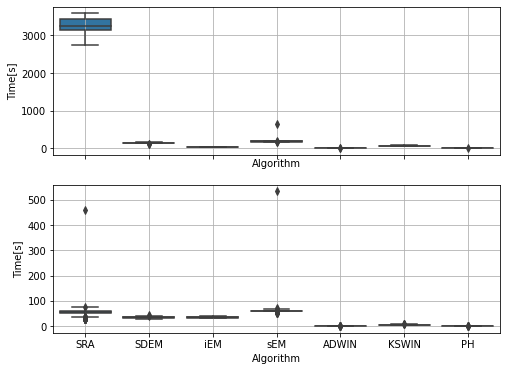

In [53]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

sns.boxplot(x='variable', y='value', data=time_by_trial_df_melted, ax=axes[0])
axes[0].set_xlabel('Algorithm')
axes[0].set_ylabel('Time[s]')
#ax.set_yscale('log')
axes[0].grid()

sns.boxplot(x='Algorithm', y='Time', data=time_by_each_df, ax=axes[1])
axes[1].set_ylabel('Time[s]')
#axes[1].set_yscale('log')
axes[1].grid()

plt.show()